In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from scipy.signal import savgol_filter

# Engine data

In [2]:
engine1 = pd.read_csv("UIPA.HMD8310H.Engine1.csv")
engine1.shape

/tmp/ipykernel_53824/2363869710.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386

(443252, 702)

In [3]:
engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

In [4]:
engine2 = pd.read_csv("UIPA.HMD8310H.Engine2.csv")
engine2.shape

/tmp/ipykernel_53824/3469547296.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386

(443369, 702)

In [5]:
engine2["battery_only"] = engine2["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)

In [6]:
merged_df = pd.merge(engine1[["aIEngineLoad", "time", "battery_only"]], engine2[["aIEngineLoad", "time"]], on='time', how='inner')
merged_df["total_load"] = merged_df["aIEngineLoad_x"] + merged_df["aIEngineLoad_y"]
merged_df.shape

(369304, 5)

In [7]:
mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")
mgo["total_vol"] = mgo["MGO_STOR_TK_C_CALC_VOL"] + mgo["MGO_STOR_TK_S_CALC_VOL"] + mgo["NO1_MGO_SERV_TK_CALC_VOL"] + mgo["NO2_MGO_SERV_TK_CALC_VOL"]

/tmp/ipykernel_53824/3850218066.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")


In [8]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df.shape

(107225, 6)

# Battery data

In [9]:
battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")
battery_data.shape

/tmp/ipykernel_53824/2709348869.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")


(477586, 111)

In [10]:
battery_columns_to_use = ["AVG_PACK_SOC", "Current", "Voltage", "time"]
for i in range(1, 8):
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_BATT_VOL")
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_CURR")
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_SOC")

In [11]:
final_df = pd.merge(engine_and_fuel_df, battery_data[battery_columns_to_use], on='time', how='inner')
final_df.shape

(107225, 30)

## Find relationship between battery power and SOC

In [438]:
# Lee Ja Yun's data
good_discharge_data = pd.read_excel("discharge_lee_ja_yun.xls")
good_discharge_data.shape

(1969, 7)

<Axes: >

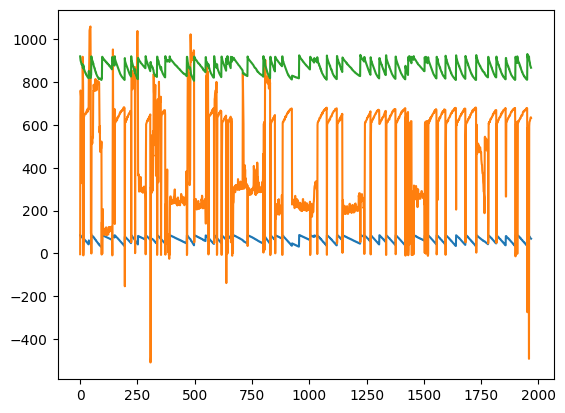

In [439]:
good_discharge_data.AvgSOC.plot()
good_discharge_data.Current.plot()
good_discharge_data.Voltage.plot()

In [440]:
end_indexes = good_discharge_data.loc[good_discharge_data["index"].diff()>1, "index"].index
segments = []
start_index = 0
for end_index in end_indexes:
    try:
        segment = good_discharge_data.loc[start_index:end_index].copy()
        segment["SOC_diff"] = segment["AvgSOC"].diff()
        segment.loc[:(segment.index[-2]), "SOC_diff"] = segment.iloc[1:]["SOC_diff"].values
        segment.drop(segment.head(1).index, inplace=True)
        segment.drop(segment.tail(1).index, inplace=True)
        drop_idx = segment[(segment["SOC_diff"]>0) | (segment["SOC_diff"]<-3)].index
        segment.drop(drop_idx, inplace=True)
        segments.append(segment)
        start_index = end_index+1
    except:
        pass

In [442]:
dataset = pd.concat(segments)
dataset.reset_index(drop=True, inplace=True)
round_power = 100000
dataset['rounded_power'] = (dataset['Power'] / round_power).round() * round_power
round_voltage = 10
dataset['rounded_voltage'] = (dataset['Voltage'] / round_voltage).round() * round_voltage
print(dataset.shape)
dataset.head()

(1556, 10)


,time,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage
0,2022-12-26T04:06:00Z,85.0,644.50,909.0,0,585850.50,4792,-2.0,600000.0,910.0
1,2022-12-26T04:07:00Z,83.0,760.80,900.5,0,685100.40,4793,-1.0,700000.0,900.0
2,2022-12-26T04:08:00Z,82.0,746.00,896.5,0,668789.00,4794,-1.0,700000.0,900.0
3,2022-12-26T04:09:00Z,81.0,731.40,893.0,0,653140.20,4795,-2.0,700000.0,890.0
4,2022-12-26T04:10:00Z,79.0,725.35,889.0,0,644836.15,4796,-1.0,600000.0,890.0


In [443]:
# We have to Add the -2.5 data class to -3
dataset[dataset["SOC_diff"]==-2.5].describe()

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage
count,7.000000,7.000000,7.000000,7.0,7.000000,7.000000,7.0,7.000000,7.000000
mean,65.857143,639.542857,861.142857,0.0,550088.100000,208614.857143,-2.5,557142.857143,862.857143
std,15.437277,24.054442,31.602629,0.0,1772.863043,92139.327779,0.0,53452.248382,34.503278
min,38.000000,610.800000,813.000000,0.0,546971.400000,4816.000000,-2.5,500000.000000,810.000000
25%,60.250000,618.900000,844.500000,0.0,549369.075000,219545.500000,-2.5,500000.000000,845.000000
50%,63.500000,646.200000,849.500000,0.0,550290.750000,228323.000000,-2.5,600000.000000,850.000000
75%,79.000000,652.875000,890.500000,0.0,551255.850000,261901.000000,-2.5,600000.000000,895.000000
max,81.000000,676.250000,895.500000,0.0,552104.700000,264272.000000,-2.5,600000.000000,900.000000


In [444]:
dataset.loc[dataset["SOC_diff"]==-2.5, "SOC_diff"] = -3

In [445]:
# Create a unique class for each unique value
print(dataset["SOC_diff"].unique())
unique_values = dataset["SOC_diff"].unique()
class_mapping = {value: class_ for class_, value in enumerate(sorted(unique_values))}

dataset['classes'] = dataset['SOC_diff'].map(class_mapping)

print("Class Mapping:", class_mapping)
# print("Mapped Classes:", )

[-2.  -1.   0.  -1.5 -3.  -0.5]
Class Mapping: {-3.0: 0, -2.0: 1, -1.5: 2, -1.0: 3, -0.5: 4, 0.0: 5}


In [446]:
dataset.head()

,time,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
0,2022-12-26T04:06:00Z,85.0,644.50,909.0,0,585850.50,4792,-2.0,600000.0,910.0,1
1,2022-12-26T04:07:00Z,83.0,760.80,900.5,0,685100.40,4793,-1.0,700000.0,900.0,3
2,2022-12-26T04:08:00Z,82.0,746.00,896.5,0,668789.00,4794,-1.0,700000.0,900.0,3
3,2022-12-26T04:09:00Z,81.0,731.40,893.0,0,653140.20,4795,-2.0,700000.0,890.0,1
4,2022-12-26T04:10:00Z,79.0,725.35,889.0,0,644836.15,4796,-1.0,600000.0,890.0,3


In [447]:
dataset[dataset["SOC_diff"]==-1].describe()

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
count,953.000000,953.000000,953.000000,953.0,953.000000,953.000000,953.0,953.000000,953.000000,953.0
mean,65.122246,555.531847,861.192025,0.0,477132.460584,158973.122770,-1.0,479118.572928,861.154250,3.0
std,13.090185,170.289933,28.296299,0.0,143914.532422,98208.300177,0.0,150400.234952,28.523364,0.0
min,30.000000,-0.950014,810.000000,0.0,-871.163297,4793.000000,-1.0,-0.000000,810.000000,3.0
25%,55.000000,472.100000,835.000000,0.0,394463.900000,47510.000000,-1.0,400000.000000,840.000000,3.0
50%,67.000000,627.550000,863.000000,0.0,549267.100000,219504.000000,-1.0,500000.000000,860.000000,3.0
75%,76.000000,657.850000,885.000000,0.0,551100.550000,256223.000000,-1.0,600000.000000,880.000000,3.0
max,85.000000,1038.450000,917.000000,0.0,854302.800000,264303.000000,-1.0,900000.000000,920.000000,3.0


In [448]:
dataset[dataset["SOC_diff"]==-2].describe()

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
count,207.000000,207.000000,207.000000,207.0,207.000000,207.000000,207.0,207.000000,207.000000,207.0
mean,62.917874,700.605072,852.734300,0.0,596399.791546,147749.198068,-2.0,600483.091787,852.898551,1.0
std,12.666676,109.792218,27.358141,0.0,87850.388273,103001.466545,0.0,100724.359305,27.293876,0.0
min,37.000000,305.100000,808.000000,0.0,260860.500000,4792.000000,-2.0,300000.000000,810.000000,1.0
25%,52.000000,637.325000,827.500000,0.0,549279.987500,37564.500000,-2.0,500000.000000,830.000000,1.0
50%,64.000000,661.750000,850.000000,0.0,551055.200000,181362.000000,-2.0,600000.000000,850.000000,1.0
75%,73.500000,746.775000,874.500000,0.0,651430.000000,256228.500000,-2.0,700000.000000,875.000000,1.0
max,85.000000,1059.600000,912.000000,0.0,868872.000000,264365.000000,-2.0,900000.000000,910.000000,1.0


In [449]:
dataset[dataset["SOC_diff"]==-3].describe()

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
count,35.000000,35.000000,35.000000,35.0,35.000000,35.000000,35.0,35.000000,35.000000,35.0
mean,61.257143,665.814286,850.214286,0.0,565918.690000,206564.714286,-3.0,580000.000000,850.571429,0.0
std,12.974733,50.223207,25.963290,0.0,44892.265996,89891.975523,0.0,63245.553203,26.562120,0.0
min,38.000000,610.800000,813.000000,0.0,546971.400000,4816.000000,-3.0,500000.000000,810.000000,0.0
25%,50.000000,634.100000,825.250000,0.0,549552.850000,219496.000000,-3.0,500000.000000,825.000000,0.0
50%,62.000000,655.450000,849.000000,0.0,550562.600000,261519.000000,-3.0,600000.000000,850.000000,0.0
75%,71.500000,671.450000,872.000000,0.0,552150.800000,262076.000000,-3.0,600000.000000,870.000000,0.0
max,81.000000,848.500000,895.500000,0.0,743286.000000,264301.000000,-3.0,700000.000000,900.000000,0.0


In [450]:
dataset[dataset["SOC_diff"]==-0.5].describe()

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
count,14.000000,14.000000,14.000000,14.0,14.000000,14.000000,14.0,14.000000,14.000000,14.0
mean,65.857143,293.632143,866.500000,0.0,253628.007143,87090.285714,-0.5,264285.714286,867.142857,4.0
std,12.321695,69.209533,28.478737,0.0,57687.912109,54781.514989,0.0,63332.369378,27.295695,0.0
min,47.500000,102.200000,829.000000,0.0,92286.600000,16309.000000,-0.5,100000.000000,830.000000,4.0
25%,55.375000,281.212500,839.500000,0.0,249750.237500,55953.250000,-0.5,225000.000000,842.500000,4.0
50%,67.750000,310.350000,866.500000,0.0,268052.350000,99142.000000,-0.5,300000.000000,870.000000,4.0
75%,76.625000,319.825000,890.250000,0.0,277816.750000,99169.750000,-0.5,300000.000000,887.500000,4.0
max,84.500000,412.750000,913.000000,0.0,345059.000000,241493.000000,-0.5,300000.000000,910.000000,4.0


In [451]:
dataset[dataset["SOC_diff"]==-1.5].describe()

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
count,59.000000,59.000000,59.000000,59.0,59.000000,59.000000,59.0,59.000000,59.000000,59.0
mean,62.567797,672.964407,852.245763,0.0,572626.659322,163844.237288,-1.5,586440.677966,852.372881,2.0
std,12.355879,78.469697,27.323158,0.0,61119.924922,100223.006365,0.0,79779.063710,27.937059,0.0
min,35.500000,500.450000,811.000000,0.0,449904.550000,4814.000000,-1.5,400000.000000,810.000000,2.0
25%,55.250000,636.600000,834.000000,0.0,549852.725000,52557.500000,-1.5,500000.000000,830.000000,2.0
50%,59.500000,655.100000,843.000000,0.0,550860.600000,224346.000000,-1.5,600000.000000,840.000000,2.0
75%,75.250000,666.575000,880.000000,0.0,552374.175000,255500.500000,-1.5,600000.000000,880.000000,2.0
max,84.500000,930.700000,908.000000,0.0,790009.425000,264271.000000,-1.5,800000.000000,910.000000,2.0


In [452]:
dataset.sort_values(by="AvgSOC")

,time,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
84,2022-12-27T01:03:00Z,30.0,522.500000,810.0,0,423225.000000,6049,-1.0,400000.0,810.0,3
83,2022-12-27T01:02:00Z,31.0,491.150000,812.0,0,398813.800000,6048,-1.0,400000.0,810.0,3
82,2022-12-27T01:01:00Z,32.0,488.250000,812.0,0,396459.000000,6047,-1.0,400000.0,810.0,3
751,2023-05-24T05:09:00Z,32.0,237.500000,818.0,0,194275.000000,192373,0.0,200000.0,820.0,5
81,2022-12-27T01:00:00Z,33.0,485.200000,813.0,0,394467.600000,6046,-1.0,400000.0,810.0,3
...,...,...,...,...,...,...,...,...,...,...,...
1101,2023-06-28T07:21:00Z,84.5,604.400000,908.0,0,548795.200000,238781,-1.5,500000.0,910.0,2
0,2022-12-26T04:06:00Z,85.0,644.500000,909.0,0,585850.500000,4792,-2.0,600000.0,910.0,1
861,2023-06-12T04:27:00Z,85.0,602.150000,910.0,0,547956.500000,219691,-1.0,500000.0,910.0,3
925,2023-06-16T06:05:00Z,85.0,-0.950014,917.0,0,-871.163297,224321,-1.0,-0.0,920.0,3


### Find linear relationship

<Axes: >

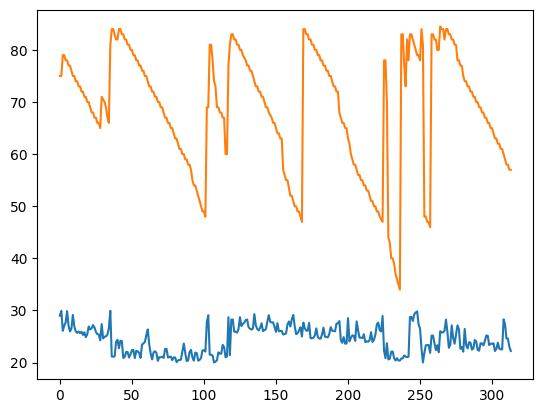

In [ ]:
filtered_data = dataset[(dataset["Power"]<300000) & (dataset["Power"]>200000)].copy()
filtered_data.reset_index(drop=True, inplace=True)
(filtered_data["Power"]/10000).plot()
filtered_data["AvgSOC"].plot()

<Axes: >

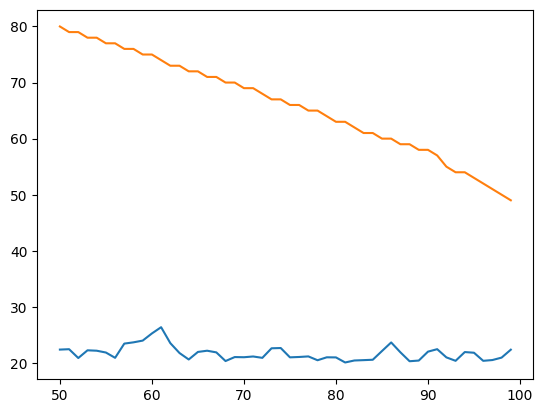

In [ ]:
(filtered_data["Power"]/10000)[50:100].plot()
filtered_data["AvgSOC"][50:100].plot()

In [ ]:
mean_SOC_diff = filtered_data["AvgSOC"][50:100].diff().mean()
mean_power = filtered_data["Power"][50:100].mean()
print(mean_power)
print(mean_SOC_diff)

217313.0575
-0.6326530612244898


### Bins approach

In [405]:
import pandas as pd

tmp = dataset.copy()

# Define bins
voltage_bins = list(range(800, 931, 10))  # 931 is the upper edge of the last bin (920-930)
Power_bins = list(range(0, 900000, 50000))         # 86 is the upper edge of the last bin (80-85)

# Bin the data
tmp['Voltage_Bin'] = pd.cut(tmp['Voltage'], bins=voltage_bins, right=False)
tmp['Power_Bin'] = pd.cut(tmp['Power'], bins=Power_bins, right=False)

# Now group by these bins
grouped = tmp.groupby(['Voltage_Bin', 'Power_Bin', "SOC_diff"])

# Example operation: Count the number of entries in each group
group_sizes = grouped.size().reset_index(name='Count')

/tmp/ipykernel_53824/394999090.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = tmp.groupby(['Voltage_Bin', 'Power_Bin', "SOC_diff"])


In [432]:
tmp

,time,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,classes,Voltage_Bin,Power_Bin
0,2022-12-26T04:06:00Z,85.0,644.50,909.0,0,585850.50,4792,-2.0,600000.0,1,"[900, 910)","[550000, 600000)"
1,2022-12-26T04:07:00Z,83.0,760.80,900.5,0,685100.40,4793,-1.0,700000.0,3,"[900, 910)","[650000, 700000)"
2,2022-12-26T04:08:00Z,82.0,746.00,896.5,0,668789.00,4794,-1.0,700000.0,3,"[890, 900)","[650000, 700000)"
3,2022-12-26T04:09:00Z,81.0,731.40,893.0,0,653140.20,4795,-2.0,700000.0,1,"[890, 900)","[650000, 700000)"
4,2022-12-26T04:10:00Z,79.0,725.35,889.0,0,644836.15,4796,-1.0,600000.0,3,"[880, 890)","[600000, 650000)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2023-08-10T08:35:00Z,39.0,677.80,814.0,0,551729.20,264303,-1.0,600000.0,3,"[810, 820)","[550000, 600000)"
1552,2023-08-10T08:36:00Z,38.0,674.60,812.0,0,547775.20,264304,-2.0,500000.0,1,"[810, 820)","[500000, 550000)"
1553,2023-08-10T08:37:00Z,36.0,677.85,811.0,0,549736.35,264305,0.0,500000.0,5,"[810, 820)","[500000, 550000)"
1554,2023-08-10T09:36:00Z,84.0,587.60,912.0,0,535891.20,264364,0.0,500000.0,5,"[910, 920)","[500000, 550000)"


In [430]:
group_sizes["Voltage_Bin"]

0       [800, 810)
1       [800, 810)
2       [800, 810)
3       [800, 810)
4       [800, 810)
           ...    
1321    [920, 930)
1322    [920, 930)
1323    [920, 930)
1324    [920, 930)
1325    [920, 930)
Name: Voltage_Bin, Length: 1326, dtype: category
Categories (13, interval[int64, left]): [[800, 810) < [810, 820) < [820, 830) < [830, 840) ... [890, 900) < [900, 910) < [910, 920) < [920, 930)]

In [431]:
import pandas as pd

# Example DataFrame with two columns of bins
data = {
    'Bin_Column1': ['Bin1', 'Bin2', 'Bin3'],
    'Bin_Column2': ['BinA', 'BinB', 'BinC']
}
df = pd.DataFrame(data)

# Example categorization function
def categorize_row(row):
    # Implement your categorization logic here
    # For example, a simple concatenation of the two bins:
    return row['Bin_Column1'] + '_' + row['Bin_Column2']

# Apply the categorization function to each row
df['Category'] = df.apply(categorize_row, axis=1)

print(df)


  Bin_Column1 Bin_Column2   Category
0        Bin1        BinA  Bin1_BinA
1        Bin2        BinB  Bin2_BinB
2        Bin3        BinC  Bin3_BinC


In [409]:
group_sizes.sort_values(by="Count", ascending=False)

,Voltage_Bin,Power_Bin,SOC_diff,Count
273,"[820, 830)","[550000, 600000)",-1.0,50
375,"[830, 840)","[550000, 600000)",-1.0,40
981,"[890, 900)","[500000, 550000)",-1.0,36
879,"[880, 890)","[500000, 550000)",-1.0,34
477,"[840, 850)","[550000, 600000)",-1.0,33
...,...,...,...,...
484,"[840, 850)","[600000, 650000)",-0.5,0
481,"[840, 850)","[600000, 650000)",-2.0,0
480,"[840, 850)","[600000, 650000)",-3.0,0
478,"[840, 850)","[550000, 600000)",-0.5,0


In [424]:
valid_groups = group_sizes[group_sizes["Count"]>0].copy()
valid_groups[valid_groups["SOC_diff"]==0]

,Voltage_Bin,Power_Bin,SOC_diff,Count
125,"[810, 820)","[150000, 200000)",0.0,1
167,"[810, 820)","[500000, 550000)",0.0,5
173,"[810, 820)","[550000, 600000)",0.0,6
185,"[810, 820)","[650000, 700000)",0.0,1
227,"[820, 830)","[150000, 200000)",0.0,5
...,...,...,...,...
1145,"[910, 920)","[150000, 200000)",0.0,1
1151,"[910, 920)","[200000, 250000)",0.0,4
1157,"[910, 920)","[250000, 300000)",0.0,4
1181,"[910, 920)","[450000, 500000)",0.0,1


In [428]:
valid_groups["Voltage_Bin"].iloc[0]

Interval(800, 810, closed='left')

In [401]:
group_sizes.groupby(["SOC_diff", "Count"]).count().to_csv("group_sizes.csv", index=True)

### Back to main approach

array([-2. , -1. ,  0. , -1.5, -3. , -0.5])

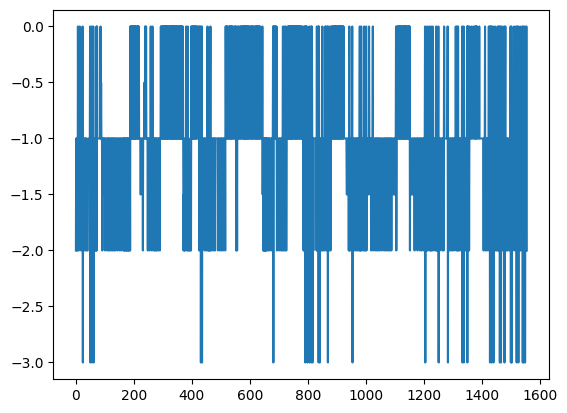

In [453]:
dataset["SOC_diff"].plot()
dataset["SOC_diff"].unique()

In [454]:
corr = dataset.set_index("time").corr()
corr

,AvgSOC,Current,Voltage,disconn,Power,index,SOC_diff,rounded_power,rounded_voltage,classes
AvgSOC,1.000000,-0.203566,0.979356,NaN,-0.110871,-0.055700,0.083512,-0.126033,0.975313,0.082715
Current,-0.203566,1.000000,-0.318451,NaN,0.994954,0.085234,-0.479514,0.965373,-0.313117,-0.492335
Voltage,0.979356,-0.318451,1.000000,NaN,-0.227019,-0.055626,0.153380,-0.237140,0.994788,0.154495
disconn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,-0.110871,0.994954,-0.227019,NaN,1.000000,0.084696,-0.477219,0.968142,-0.221996,-0.490267
index,-0.055700,0.085234,-0.055626,NaN,0.084696,1.000000,-0.032845,0.082929,-0.055867,-0.025244
SOC_diff,0.083512,-0.479514,0.153380,NaN,-0.477219,-0.032845,1.000000,-0.466581,0.149633,0.994332
rounded_power,-0.126033,0.965373,-0.237140,NaN,0.968142,0.082929,-0.466581,1.000000,-0.232319,-0.478325
rounded_voltage,0.975313,-0.313117,0.994788,NaN,-0.221996,-0.055867,0.149633,-0.232319,1.000000,0.150822
classes,0.082715,-0.492335,0.154495,NaN,-0.490267,-0.025244,0.994332,-0.478325,0.150822,1.000000


<Axes: >

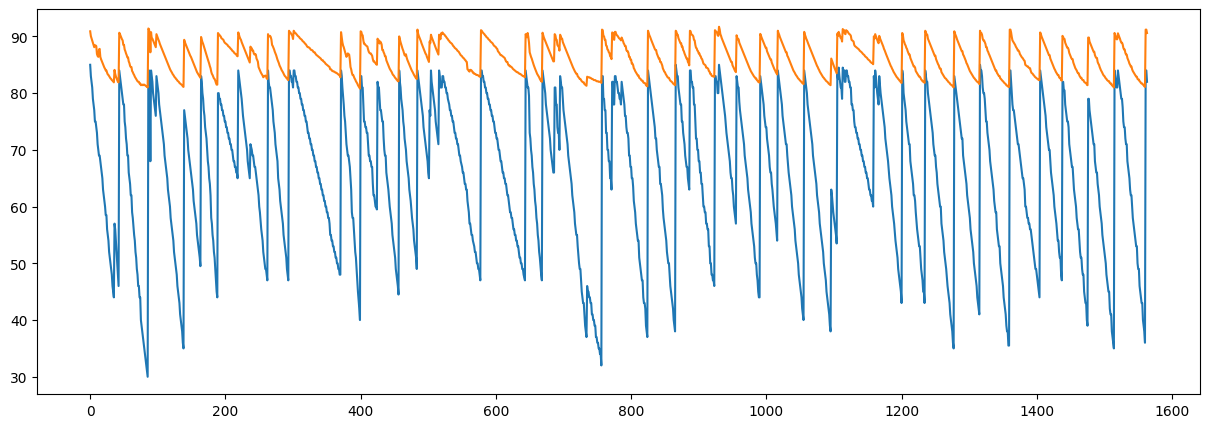

In [237]:
plt.figure(figsize=(15,5))
dataset["AvgSOC"].plot()
(dataset["Voltage"]/10).plot()

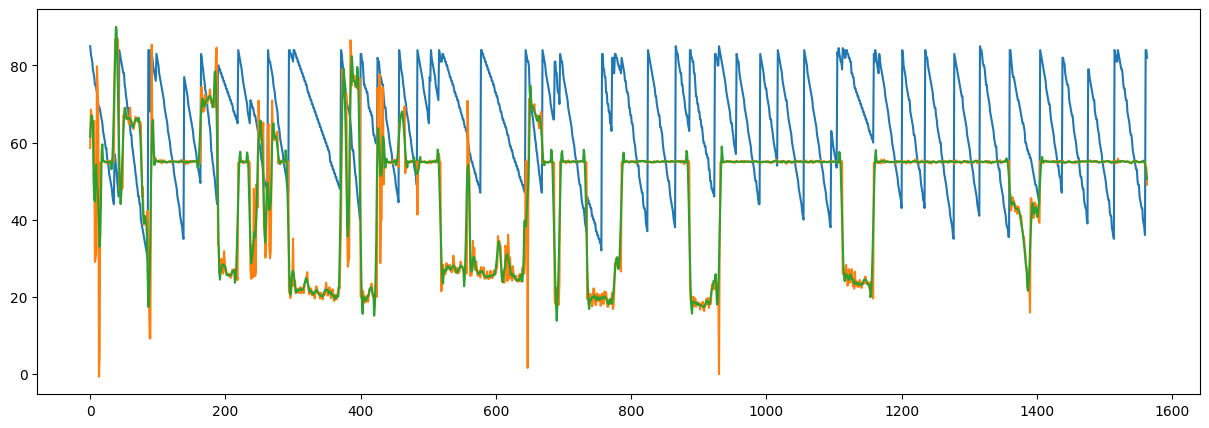

In [238]:
plt.figure(figsize=(15,5))
dataset["AvgSOC"].plot()
(dataset["Power"]/10000).plot()
savgol_data = savgol_filter(dataset["Power"], 10, 2)
plt.plot(savgol_data/10000)

In [455]:
train_features = ["rounded_power", "rounded_voltage"]
data = dataset[["classes", "rounded_power", "rounded_voltage"]]
X = data[train_features]
y = data["classes"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

In [456]:
scaler = MinMaxScaler()
# X_train = X_train.values.reshape(-1, 1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_one_hot = to_categorical(y_train, num_classes=6)
y_test_one_hot = to_categorical(y_test, num_classes=6)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(1400, 2)
(156, 2)
(1400,)
(156,)
(1400, 6)
(156, 6)


In [457]:

# Create the model
model = Sequential()
model.add(Dense(64, input_dim=2, activation='relu'))  # First hidden layer with 64 neurons
model.add(Dense(32, activation='relu'))  # Second hidden layer with 32 neurons
model.add(Dense(6, activation='softmax'))  # Output layer with 6 neurons, one for each class

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model fit
model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32)  # Uncomment this line to train the model

Epoch 1/100
44/44 [==============================] - 0s 599us/step - loss: 1.5758 - accuracy: 0.5321
Epoch 2/100
44/44 [==============================] - 0s 558us/step - loss: 1.1747 - accuracy: 0.6171
Epoch 3/100
44/44 [==============================] - 0s 514us/step - loss: 1.0957 - accuracy: 0.6171
Epoch 4/100
44/44 [==============================] - 0s 533us/step - loss: 1.0713 - accuracy: 0.6157
Epoch 5/100
44/44 [==============================] - 0s 505us/step - loss: 1.0507 - accuracy: 0.6179
Epoch 6/100
44/44 [==============================] - 0s 546us/step - loss: 1.0370 - accuracy: 0.6164
Epoch 7/100
44/44 [==============================] - 0s 524us/step - loss: 1.0263 - accuracy: 0.6136
Epoch 8/100
44/44 [==============================] - 0s 574us/step - loss: 1.0222 - accuracy: 0.6143
Epoch 9/100
44/44 [==============================] - 0s 533us/step - loss: 1.0102 - accuracy: 0.6114
Epoch 10/100
44/44 [==============================] - 0s 548us/step - loss: 1.0011 - accura

In [458]:
y_pred = model.predict(X_train)
predictions = np.argmax(y_pred, axis=1)
print(accuracy_score(predictions, y_train))

y_pred = model.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
print(accuracy_score(predictions, y_test))

44/44 [==============================] - 0s 463us/step
0.6264285714285714
5/5 [==============================] - 0s 598us/step
0.5705128205128205


In [459]:
y_train_one_hot

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [474]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 2
[LightGBM] [Info] Start training from score -4.153185
[LightGBM] [Info] Start training from score -2.029292
[LightGBM] [Info] Start training from score -3.236894
[LightGBM] [Info] Start training from score -0.482655
[LightGBM] [Info] Start training from score -4.605170
[LightGBM] [Info] Start training from score -1.679707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

LGBMClassifier(n_estimators=1000)

In [475]:
from sklearn.metrics import accuracy_score

y_pred = lgbm.predict(X_train)
print(accuracy_score(y_pred, y_train))
# plt.plot(y_pred[:100])
# plt.plot(y_train[:100])

# plt.figure()
y_pred = lgbm.predict(X_test)
print(accuracy_score(y_pred, y_test))
# plt.plot(y_pred[:100])
# plt.plot(y_test[:100].reset_index(drop=True))

0.6407142857142857
0.5705128205128205


In [184]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_train)
mean_squared_error(y_pred, y_train)

44/44 [==============================] - 0s 448us/step


0.33741397281818525

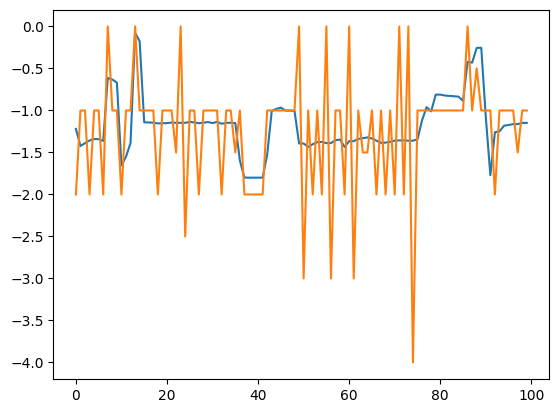

In [145]:
plt.plot(y_pred[:100])
plt.plot(y_train[:100])

In [66]:
segment.tail(1).index

RangeIndex(start=1959, stop=1960, step=1)

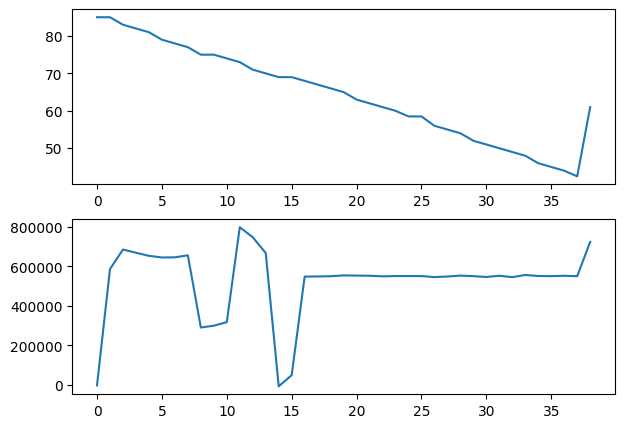

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(7, 5)) # 4x4 grid of axes
for segment in segments[:1]:
    axs[0].plot(segment.AvgSOC)
    axs[1].plot(segment.Power)
    # segment.AvgSOC.plot()
    # plt.figure(figsize=(7, 5))
    # segment.Power.plot()
    # plt.figure()
    # segment.Voltage.plot()

<Axes: >

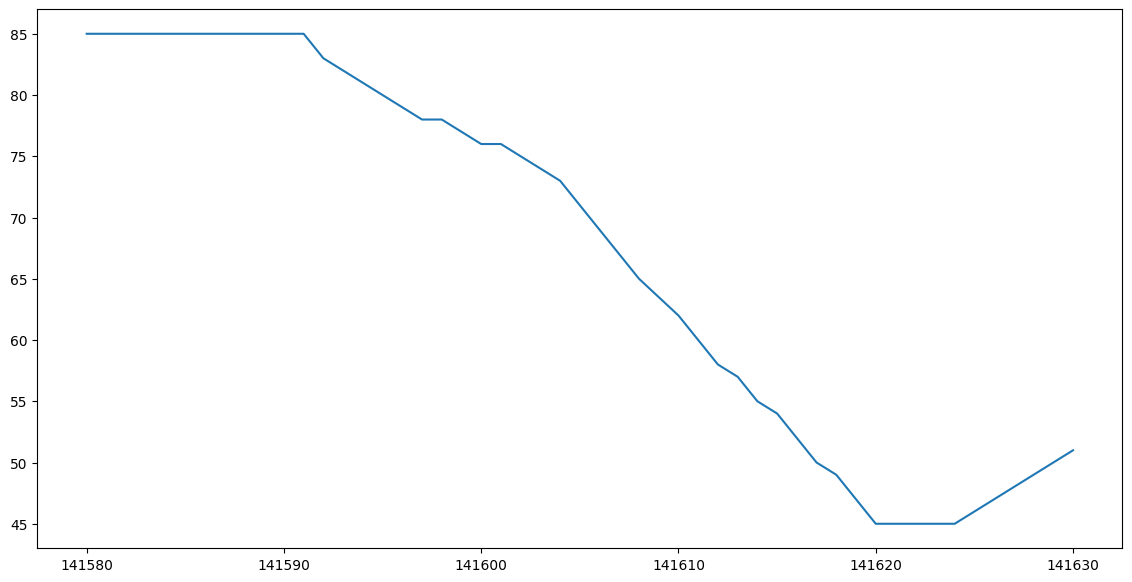

In [61]:
plt.figure(figsize=(14, 7))
filtered_soc_data = battery_data[battery_data["AVG_PACK_SOC"]<=100]
filtered_soc_data.loc[141580:141630, "PACK1_CRIDATA_SOC"].plot()

In [89]:
upper_bound = 100
lower_bound = 20
segments = []
start_idx = None

for idx in filtered_soc_data.index:
    soc_value = filtered_soc_data.loc[idx, 'AVG_PACK_SOC']
    if start_idx is None and soc_value < upper_bound:
        start_idx = idx  # start of a new segment
    elif start_idx is not None and soc_value < lower_bound:
        # end of the current segment
        if idx - 1 != start_idx:  # check to ensure the segment is more than 1 data point
            segments.append((start_idx, idx - 1))
        start_idx = None

<Axes: >

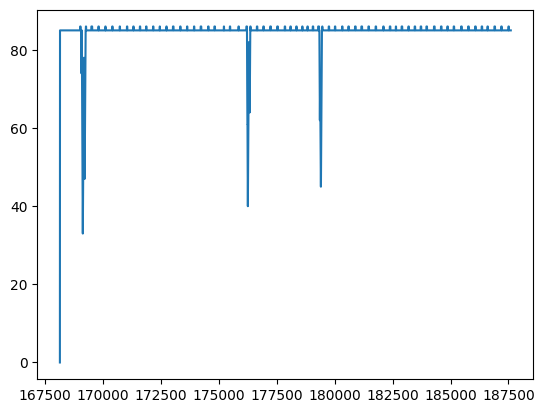

In [129]:
avg_soc_good_segment_idx = [16, 25, 31] # I stopped checking at 31

good_data_start_idx = [116300, 141580, 147400, 148800, 154750, 156000, 169000, 176100, 179300]
good_data_end_idx = [116500, 141650, 147500, 149000, 154950, 156200, 169300, 176400, 179500]

start, end = segments[31]
soc_data = filtered_soc_data.loc[start:end, "AVG_PACK_SOC"]
soc_data.plot()

<Axes: >

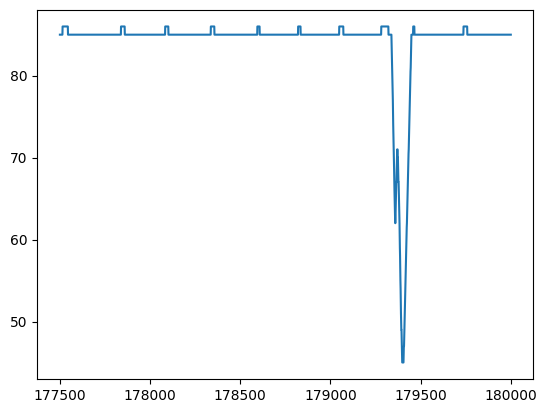

In [134]:
soc_data = filtered_soc_data.loc[177500:180000, "AVG_PACK_SOC"]
soc_data.plot()

<Axes: >

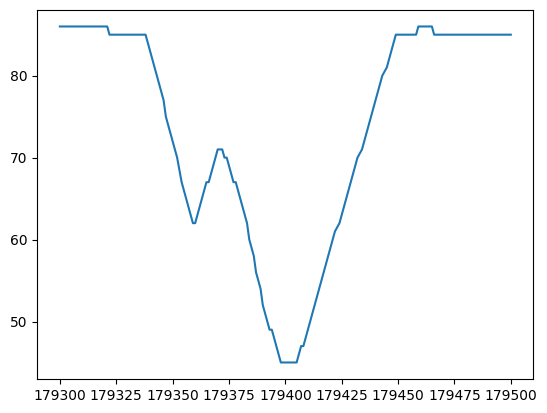

In [136]:
soc_data = filtered_soc_data.loc[179300:179500, "AVG_PACK_SOC"]
soc_data.plot()

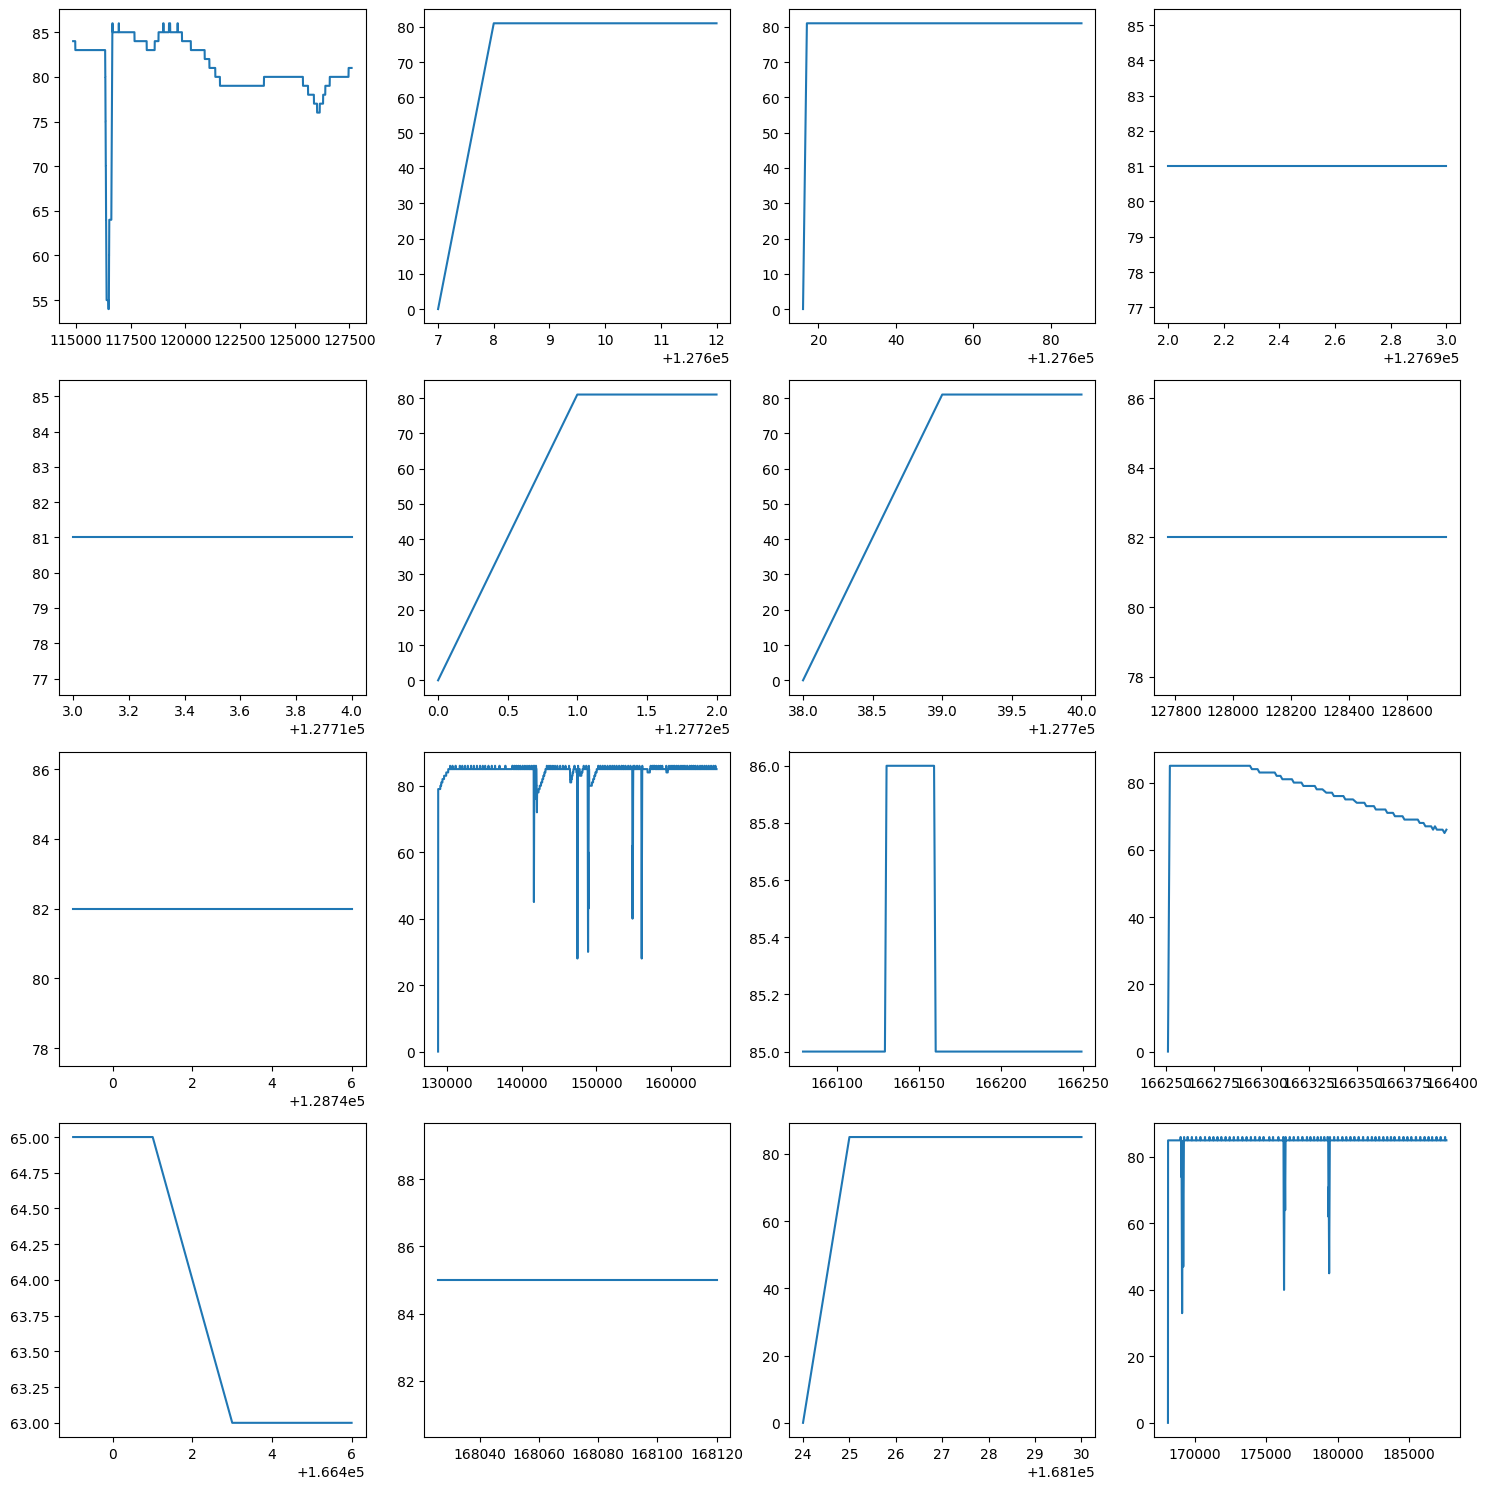

In [95]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15)) # 4x4 grid of axes

for i in range(4):
    for j in range(4):
        start, end = segments[16+4*i + j]
        soc_data = filtered_soc_data.loc[start:end, "AVG_PACK_SOC"]
        axs[i, j].plot(soc_data)

plt.tight_layout() # Adjusts the plots to fit into the figure area.
plt.show()

# for start, end in segments[10:20]:
#     plt.figure()
#     soc_data = filtered_soc_data.loc[start:end, "AVG_PACK_SOC"]
#     soc_data.plot()

# Optimize power split

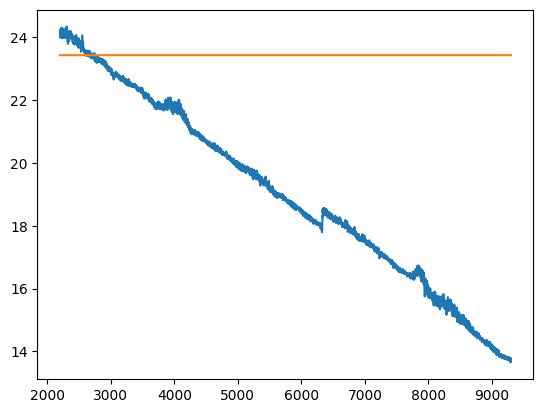

In [23]:
noise_start_point = 2200
noise_end_point = 9300
fuel_data = engine_and_fuel_df["total_vol"][noise_start_point:noise_end_point]
load_data = engine_and_fuel_df["total_load"][noise_start_point:noise_end_point]
(fuel_data).plot()
plt.plot(load_data.index, np.ones(load_data.shape)*load_data.mean()/10)

<Axes: >

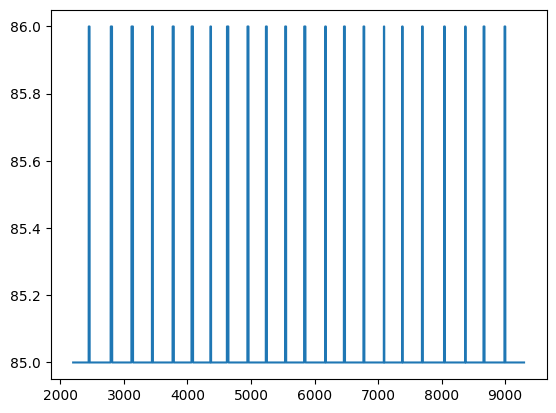

In [37]:
noise_start_point = 2200
noise_end_point = 9300
final_df["PACK1_CRIDATA_SOC"][noise_start_point:noise_end_point].plot()

In [28]:
final_df.columns

Index(['aIEngineLoad_x', 'time', 'battery_only', 'aIEngineLoad_y',
       'total_load', 'AVG_PACK_SOC', 'Current', 'Voltage',
       'PACK1_CRIDATA_BATT_VOL', 'PACK1_CRIDATA_CURR', 'PACK1_CRIDATA_SOC',
       'PACK2_CRIDATA_BATT_VOL', 'PACK2_CRIDATA_CURR', 'PACK2_CRIDATA_SOC',
       'PACK3_CRIDATA_BATT_VOL', 'PACK3_CRIDATA_CURR', 'PACK3_CRIDATA_SOC',
       'PACK4_CRIDATA_BATT_VOL', 'PACK4_CRIDATA_CURR', 'PACK4_CRIDATA_SOC',
       'PACK5_CRIDATA_BATT_VOL', 'PACK5_CRIDATA_CURR', 'PACK5_CRIDATA_SOC',
       'PACK6_CRIDATA_BATT_VOL', 'PACK6_CRIDATA_CURR', 'PACK6_CRIDATA_SOC',
       'PACK7_CRIDATA_BATT_VOL', 'PACK7_CRIDATA_CURR', 'PACK7_CRIDATA_SOC'],
      dtype='object')